Epoch 0: Train Loss 0.7566, Test Loss 0.6419
Train Accuracy: 0.5000, Test Accuracy: 0.7450
Epoch 1: Train Loss 0.7005, Test Loss 0.6034
Train Accuracy: 0.4900, Test Accuracy: 0.7450
Epoch 2: Train Loss 0.7151, Test Loss 0.6342
Train Accuracy: 0.5000, Test Accuracy: 0.7450
Epoch 3: Train Loss 0.6876, Test Loss 0.7072
Train Accuracy: 0.5000, Test Accuracy: 0.2550
Epoch 4: Train Loss 0.6642, Test Loss 0.7961
Train Accuracy: 0.7550, Test Accuracy: 0.2550
Epoch 5: Train Loss 0.6607, Test Loss 0.8556
Train Accuracy: 0.5000, Test Accuracy: 0.2550
Epoch 6: Train Loss 0.6606, Test Loss 0.8633
Train Accuracy: 0.5000, Test Accuracy: 0.2550
Epoch 7: Train Loss 0.6499, Test Loss 0.8294
Train Accuracy: 0.5000, Test Accuracy: 0.2550
Epoch 8: Train Loss 0.6314, Test Loss 0.7778
Train Accuracy: 0.6650, Test Accuracy: 0.2550
Epoch 9: Train Loss 0.6148, Test Loss 0.7334
Train Accuracy: 0.7300, Test Accuracy: 0.2600
Epoch 10: Train Loss 0.6045, Test Loss 0.7145
Train Accuracy: 0.7750, Test Accuracy: 0.330

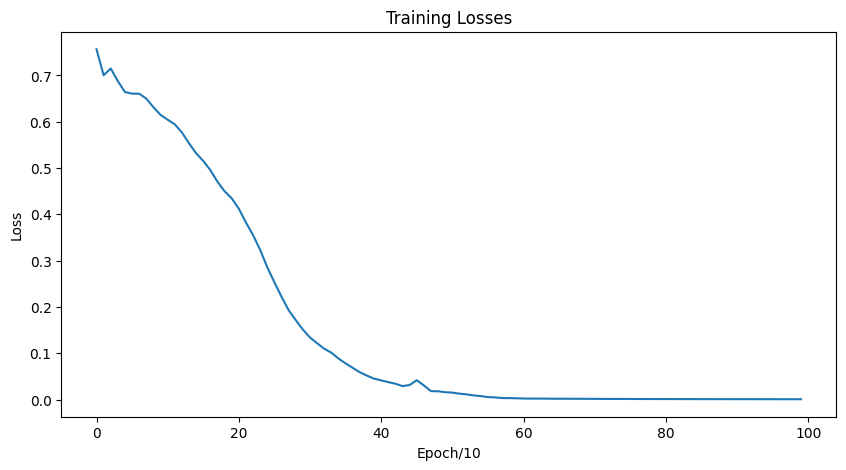

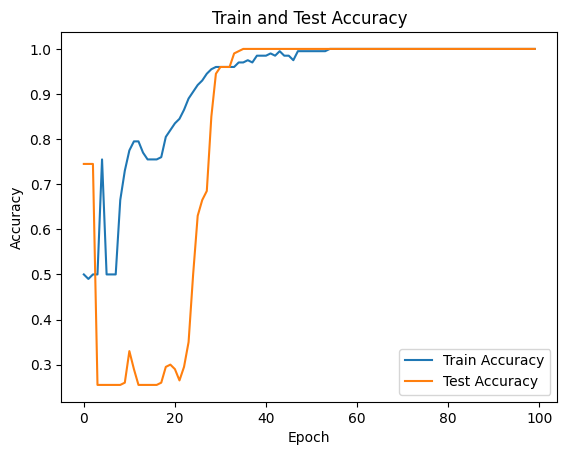

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math


class PositionalEncoding(nn.Module):
    def __init__(self, hidden_size, max_len=500):
        super().__init__()
        
        # Create positional encodings
        pe = torch.zeros(max_len, hidden_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_size, 2).float() * (-math.log(10000.0) / hidden_size))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:x.size(1), :].unsqueeze(0)

class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_size = hidden_size // num_heads
        
        self.query_proj = nn.Linear(hidden_size, hidden_size)
        self.key_proj = nn.Linear(hidden_size, hidden_size)
        self.value_proj = nn.Linear(hidden_size, hidden_size)
        self.output_proj = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()
        
        # Project inputs
        Q = self.query_proj(x).view(batch_size, seq_len, self.num_heads, self.head_size)
        K = self.key_proj(x).view(batch_size, seq_len, self.num_heads, self.head_size)
        V = self.value_proj(x).view(batch_size, seq_len, self.num_heads, self.head_size)
        
        # Transpose for attention computation
        Q = Q.transpose(1, 2)  # [batch, heads, seq_len, head_size]
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)
        
        # Compute attention scores
        attention_scores = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(self.head_size)
        
        # Apply mask (only for non-padding keys)
        if mask is not None:
            attention_scores = attention_scores.masked_fill(
                mask.unsqueeze(1).unsqueeze(2) == 0, float('-inf')
            )
        
        # Softmax and attention
        attention_probs = torch.softmax(attention_scores, dim=-1)
        context = torch.matmul(attention_probs, V)
        
        # Reshape and project
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.hidden_size)
        return self.output_proj(context)

class TransformerBlock(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super().__init__()
        self.attention = MultiHeadAttention(hidden_size, num_heads)
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        
        # MLP
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )
        self.layer_norm2 = nn.LayerNorm(hidden_size)
    
    def forward(self, x, mask=None):
        # Attention with residual connection
        attn_output = self.attention(self.layer_norm1(x), mask)
        x = x + attn_output
        
        # MLP with residual connection
        mlp_output = self.mlp(self.layer_norm2(x))
        x = x + mlp_output
        
        return x

class ANBNTransformer(nn.Module):
    def __init__(self, vocab_size, hidden_size=56, num_heads=2, max_len=202):
        super().__init__()
        
        # Embedding matrices
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.pos_encoding = PositionalEncoding(hidden_size, max_len)
        
        # Final layer norm
        self.final_layer_norm = nn.LayerNorm(hidden_size)
        
        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads) 
            for _ in range(3)
        ])
        
        # Classification head
        self.classifier = nn.Linear(hidden_size, 2)
    
    def forward(self, x, mask=None):
        # Embedding and positional encoding
        x = self.embedding(x)
        x = self.pos_encoding(x)
        
        # Transformer blocks
        for block in self.transformer_blocks:
            x = block(x, mask)
        
        # Final layer norm
        x = self.final_layer_norm(x)
        
        # Classification (using start token)
        logits = self.classifier(x[:, 0, :])
        return logits

def tokenize(string, max_len=202):
    """
    Tokenize a string according to the specified mapping
    1: start symbol
    3: 'a'
    4: 'b'
    2: end symbol
    0: padding
    """
    base = [1] + [3 if char == 'a' else 4 for char in string] + [2]
    return base + [0] * (max_len - len(base))

def generate_anbn_dataset(is_train=True):
    """
    Generate A^nB^n dataset
    
    For training:
    - 100 positive samples from length 1 to 100
    - 100 negative samples of even length less than 100
    
    For testing:
    - 100 positive samples from length 100 to 200
    - 100 negative samples from length 100 to 200
    """
    X, y = [], []
    
    if is_train:
        # Positive samples (1 to 100 length)
        for n in range(1, 101):
            string = "a" * n + "b" * n
            X.append(tokenize(string))
            y.append(1)
        
        # Negative samples (even length less than 100)
        while len(y) < 200:
            # Generate random even length strings less than 100
            length = np.random.randint(2, 100) 
            if length % 2 == 1:
                length += 1
            
            # Ensure the string is not a valid A^nB^n
            while True:
                # Generate a random string of the specified length
                string = ''.join(np.random.choice(['a', 'b'], length))
                
                # Check it's not a valid A^nB^n
                a_count = string.count('a')
                b_count = string.count('b')
                if a_count != b_count or a_count == 0:
                    X.append(tokenize(string))
                    y.append(0)
                    break
    else:
        # Positive samples (length 100 to 200)
        for n in range(100, 201):
            if n % 2 == 0:
                string = "a" * (n//2) + "b" * (n//2)
                X.append(tokenize(string))
                y.append(1)
        
        # Negative samples (length 100 to 200)
        while len(y) < 200:
            # Generate random even length strings between 100 and 200
            length = np.random.randint(100, 201)
            if length % 2 == 1:
                length += 1
            
            # Ensure the string is not a valid A^nB^n
            while True:
                string = ''.join(np.random.choice(['a', 'b'], length))
                
                # Check it's not a valid A^nB^n
                a_count = string.count('a')
                b_count = string.count('b')
                if a_count != b_count or a_count == 0:
                    X.append(tokenize(string))
                    y.append(0)
                    break
    
    return torch.tensor(X), torch.tensor(y)

def train_model(model, X_train, y_train, X_test, y_test, epochs=100, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # List to track training losses
    train_losses = []
    train_accs = []
    test_accs = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        
        # Create mask (1 for non-padding, 0 for padding)
        train_mask = (X_train != 0).float()
        
        outputs = model(X_train, train_mask)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        # Record training loss
        train_losses.append(loss.item())
        
        # Periodic evaluation
        if epoch % 1 == 0:
            model.eval()
            with torch.no_grad():
                test_mask = (X_test != 0).float()
                test_outputs = model(X_test, test_mask)
                test_loss = criterion(test_outputs, y_test)
                
                train_pred = outputs.argmax(dim=1)
                test_pred = test_outputs.argmax(dim=1)
                
                train_acc = (train_pred == y_train).float().mean()
                train_accs.append(train_acc.item())
                test_acc = (test_pred == y_test).float().mean()
                test_accs.append(test_acc.item())
                
                print(f"Epoch {epoch}: Train Loss {loss.item():.4f}, Test Loss {test_loss.item():.4f}")
                print(f"Train Accuracy: {train_acc.item():.4f}, Test Accuracy: {test_acc.item():.4f}")
    
    return model, train_losses, train_accs, test_accs

def train_():
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Hyperparameters
    vocab_size = 5  # [start(1), pad(0), end(2), a(3), b(4)]
    hidden_size = 56
    num_heads = 2
    
    # Create dataset
    X_train, y_train = generate_anbn_dataset(is_train=True)
    X_test, y_test = generate_anbn_dataset(is_train=False)
    
    # Create model
    model = ANBNTransformer(vocab_size, hidden_size, num_heads)
    
    # Train model
    trained_model, train_losses, trains_accs, test_accs = train_model(model, X_train, y_train, X_test, y_test)
    
    # Plotting training losses (optional)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses)
    plt.title('Training Losses')
    plt.xlabel('Epoch/10')
    plt.ylabel('Loss')
    plt.show()
    
    return trained_model, X_train, y_train, X_test, y_test, train_losses, trains_accs, test_accs


model, X_train, y_train, X_test, y_test, train_losses, trains_accs, test_accs = train_()
import matplotlib.pyplot as plt
plt.plot(trains_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.legend()
plt.title('Train and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()




Epoch 1/200, Loss: 0.9671, Accuracy: 91.00%
Epoch 2/200, Loss: 0.7613, Accuracy: 91.00%
Epoch 3/200, Loss: 0.6403, Accuracy: 91.00%
Epoch 4/200, Loss: 0.5055, Accuracy: 91.00%
Epoch 5/200, Loss: 0.4373, Accuracy: 91.00%
Epoch 6/200, Loss: 0.4114, Accuracy: 91.00%
Epoch 7/200, Loss: 0.3915, Accuracy: 91.00%
Epoch 8/200, Loss: 0.3362, Accuracy: 91.00%
Epoch 9/200, Loss: 0.3369, Accuracy: 91.00%
Epoch 10/200, Loss: 0.3334, Accuracy: 91.00%
Epoch 11/200, Loss: 0.3323, Accuracy: 91.00%
Epoch 12/200, Loss: 0.3242, Accuracy: 92.00%
Epoch 13/200, Loss: 0.2601, Accuracy: 92.00%
Epoch 14/200, Loss: 0.2664, Accuracy: 92.00%
Epoch 15/200, Loss: 0.3161, Accuracy: 92.00%
Epoch 16/200, Loss: 0.2466, Accuracy: 92.00%
Epoch 17/200, Loss: 0.2060, Accuracy: 92.00%
Epoch 18/200, Loss: 0.2223, Accuracy: 92.00%
Epoch 19/200, Loss: 0.2494, Accuracy: 92.00%
Epoch 20/200, Loss: 0.1920, Accuracy: 92.00%
Epoch 21/200, Loss: 0.1807, Accuracy: 92.00%
Epoch 22/200, Loss: 0.1872, Accuracy: 92.00%
Epoch 23/200, Loss:

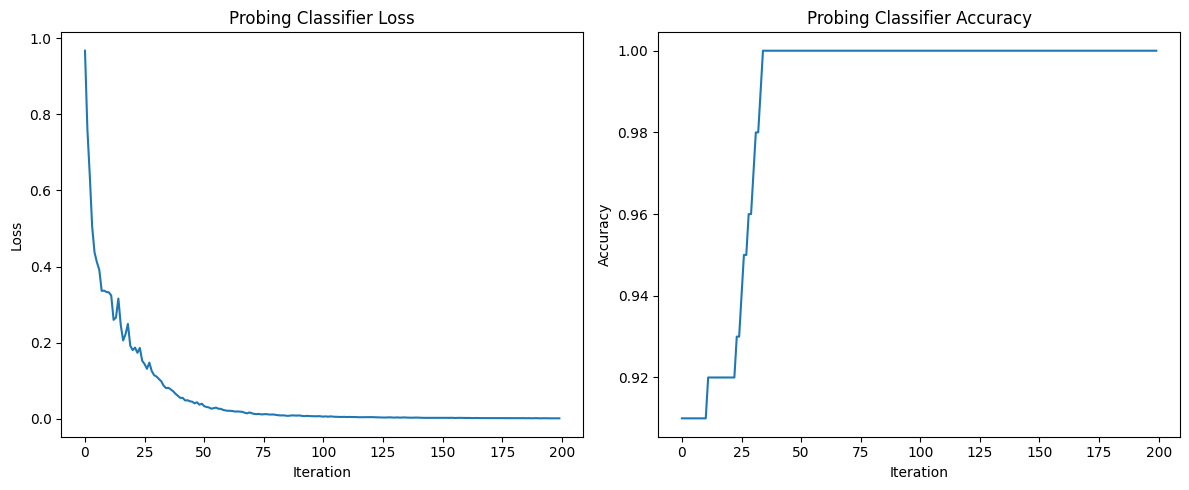

Probing Classifier Accuracy: 100.00%


In [32]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

class ProbingClassifier(nn.Module):
    def __init__(self, embed_dim, output_dim=1):
        """
        Probing classifier for stack depth prediction
        
        Args:
        - embed_dim: Dimensionality of input representations
        - output_dim: Number of output classes
        """
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.Linear(embed_dim // 2, output_dim)
        )
    
    def forward(self, x):
        return self.classifier(x)

def simulate_stack_depth_classes(sequence):
    """
    Convert stack depth to classification labels
    
    Args:
    - sequence: Input sequence of tokens
    - num_classes: Number of depth classes to use
    
    Returns:
    - List of depth class labels for each token
    """
    stack_depths = []
    stack = []
    
    for token in sequence:
        if token == 1:  # start symbol
            stack_depths.append(0)
        elif token == 3:  # 'a'
            stack.append('a')
            stack_depths.append(len(stack))
        elif token == 4:  # 'b'
            if stack and stack[-1] == 'a':
                stack.pop()
            stack_depths.append(len(stack))
        elif token == 2:  # end symbol
            stack_depths.append(len(stack))
        else:  # padding
            stack_depths.append(0)
    
    return stack_depths

def extract_last_layer_representations(model, sequences):
    """
    Extract representations from the last transformer layer
    
    Args:
    - model: Trained transformer model
    - sequences: Input sequences
    
    Returns:
    - Extracted representations
    """
    model.eval()
    
    with torch.no_grad():
        x = model.embedding(sequences)
        x = model.pos_encoding(x)
        
        for block in model.transformer_blocks:
            x = block(x)
        
        # Final layer norm
        x = model.final_layer_norm(x)
    
    return x


def train_probing_classifier(model, sequences, num_classes=2, epochs=10, batch_size=64):
    """
    Train probing classifier for stack depth
    
    Args:
    - model: Trained transformer model
    - sequences: Input sequences
    - num_classes: Number of depth classes
    - epochs: Number of training epochs
    - batch_size: Batch size for training
    
    Returns:
    - Trained probing model
    - Training losses
    - Training accuracies
    """
    # Extract representations from last layer
    representations = extract_last_layer_representations(model, sequences)
    
    # Generate depth class labels
    labels = torch.tensor([
        simulate_stack_depth_classes(seq) 
        for seq in sequences
    ])
    
    # Prepare data for classification
    # Use the first token's representation and corresponding label
    features = representations[:, 0, :]
    first_token_labels = labels[:, 0]
    
    # Create dataset and dataloader
    dataset = TensorDataset(features, first_token_labels)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Move to device
    device = next(model.parameters()).device
    
    # Initialize probing model
    probing_model = ProbingClassifier(
        embed_dim=features.shape[1], 
        output_dim=num_classes
    ).to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(probing_model.parameters(), lr=1e-3)
    
    # Tracking variables
    loss_probe = []
    accuracy_probe = []
    
    # Training loop
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        probing_model.train()
        
        for batch_features, batch_labels in data_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)
            
            # Forward pass
            outputs = probing_model(batch_features)
            loss = criterion(outputs, batch_labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Tracking metrics
            total_loss += loss.item()
            
            # Accuracy calculation
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == batch_labels).sum().item()
            total += batch_labels.size(0)
        
        # Append loss and accuracy for the epoch
        loss_probe.append(total_loss / len(data_loader))
        accuracy_probe.append(correct / total)
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(data_loader):.4f}, Accuracy: {correct / total:.2%}")
    
    return probing_model, loss_probe, accuracy_probe

def evaluate_probing_classifier(model, probing_model, sequences, num_classes=2):
    """
    Evaluate probing classifier
    
    Args:
    - model: Original transformer model
    - probing_model: Trained probing model
    - sequences: Input sequences
    - num_classes: Number of depth classes
    
    Returns:
    - Probing accuracy
    """
    # Extract representations
    representations = extract_last_layer_representations(model, sequences)
    
    # Generate depth class labels
    labels = torch.tensor([
        simulate_stack_depth_classes(seq) 
        for seq in sequences
    ])
    
    # Use first token's representation and label
    features = representations[:, 0, :]
    first_token_labels = labels[:, 0]
    
    # Move to device
    device = next(model.parameters()).device
    features = features.to(device)
    first_token_labels = first_token_labels.to(device)
    
    # Evaluate
    probing_model.eval()
    with torch.no_grad():
        outputs = probing_model(features)
        predictions = torch.argmax(outputs, dim=1)
        accuracy = (predictions == first_token_labels).sum().item() / first_token_labels.size(0)
    
    print(f"Probing Classifier Accuracy: {accuracy:.2%}")
    return accuracy

def visualize_probing_results(loss_probe, accuracy_probe):
    """
    Visualize probing training results
    
    Args:
    - loss_probe: List of training losses
    - accuracy_probe: List of training accuracies
    """
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(loss_probe)
    plt.title('Probing Classifier Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_probe)
    plt.title('Probing Classifier Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.show()

def run_stack_depth_probing(model, X_train, y_train, X_test, y_test):
    """
    Run complete stack depth probing experiment
    
    Args:
    - model: Trained transformer model
    - X_train, y_train, X_test, y_test: Training and test data
    
    Returns:
    - Probing model
    - Probing results
    """
    # Filter for positive samples
    train_pos = X_train[y_train == 1]
    test_pos = X_test[y_test == 1]
    loss_probe = []
    accuracy_probe = []
    # Train probing classifier
    probing_model, loss_probe, accuracy_probe = train_probing_classifier(
        model, train_pos, num_classes=3, epochs=200
    )
    
    # Visualize training results
    visualize_probing_results(loss_probe, accuracy_probe)
    
    # Evaluate on test set
    test_accuracy = evaluate_probing_classifier(
        model, probing_model, test_pos, num_classes=3
    )
    
    return probing_model, {
        'loss': loss_probe,
        'accuracy': accuracy_probe,
        'test_accuracy': test_accuracy
    }

# Run the probing experiment
probing_results = run_stack_depth_probing(model, X_train, y_train, X_test, y_test)

Epoch 1/200, Loss: 0.7031, Accuracy: 100.00%
Epoch 2/200, Loss: 0.5778, Accuracy: 100.00%
Epoch 3/200, Loss: 0.4708, Accuracy: 100.00%
Epoch 4/200, Loss: 0.3802, Accuracy: 100.00%
Epoch 5/200, Loss: 0.3039, Accuracy: 100.00%
Epoch 6/200, Loss: 0.2411, Accuracy: 100.00%
Epoch 7/200, Loss: 0.1901, Accuracy: 100.00%
Epoch 8/200, Loss: 0.1489, Accuracy: 100.00%
Epoch 9/200, Loss: 0.1167, Accuracy: 100.00%
Epoch 10/200, Loss: 0.0912, Accuracy: 100.00%
Epoch 11/200, Loss: 0.0715, Accuracy: 100.00%
Epoch 12/200, Loss: 0.0566, Accuracy: 100.00%
Epoch 13/200, Loss: 0.0450, Accuracy: 100.00%
Epoch 14/200, Loss: 0.0363, Accuracy: 100.00%
Epoch 15/200, Loss: 0.0294, Accuracy: 100.00%
Epoch 16/200, Loss: 0.0242, Accuracy: 100.00%
Epoch 17/200, Loss: 0.0202, Accuracy: 100.00%
Epoch 18/200, Loss: 0.0170, Accuracy: 100.00%
Epoch 19/200, Loss: 0.0145, Accuracy: 100.00%
Epoch 20/200, Loss: 0.0125, Accuracy: 100.00%
Epoch 21/200, Loss: 0.0110, Accuracy: 100.00%
Epoch 22/200, Loss: 0.0097, Accuracy: 100.0

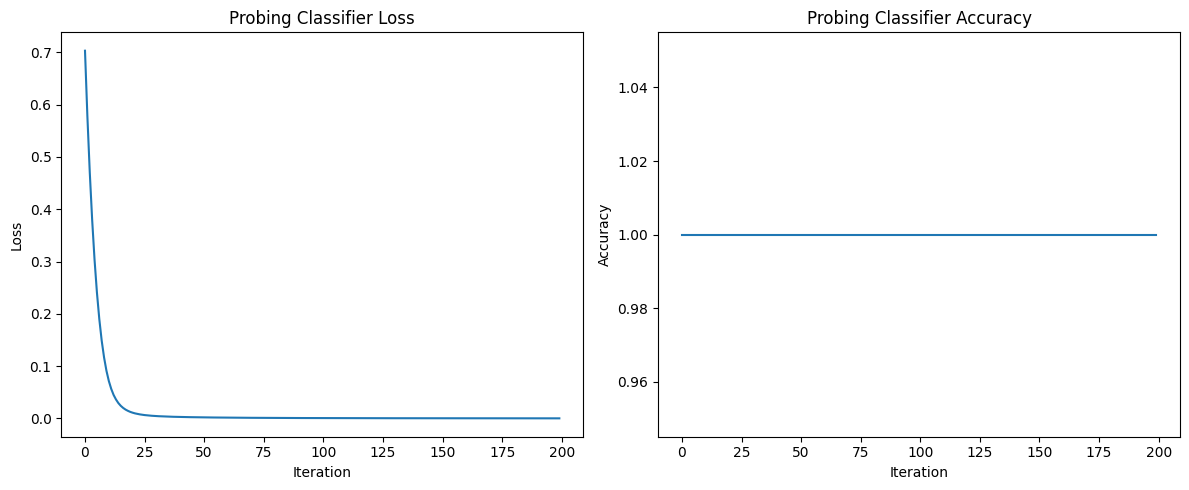

Probing Classifier Accuracy: 100.00%


In [41]:
vocab_size = 5 
hidden_size = 56
num_heads = 2
model_untrained = ANBNTransformer(vocab_size, hidden_size, num_heads)
probing_results_untrained = run_stack_depth_probing(model_untrained, X_train, y_train, X_test, y_test)

In [42]:
def test_model(model, X_test, y_test):
    criterion = nn.CrossEntropyLoss()
    test_accs = []

    model.eval()
    with torch.no_grad():
        test_mask = (X_test != 0).float()
        test_outputs = model(X_test, test_mask)
        test_loss = criterion(test_outputs, y_test)
        test_pred = test_outputs.argmax(dim=1)
        test_acc = (test_pred == y_test).float().mean()
        test_accs.append(test_acc.item())
        
        print(f"Test Loss {test_loss.item():.4f}")
        print(f"Test Accuracy: {test_acc.item():.4f}")
    
    return model, test_accs

In [44]:
import pickle

with open('model_anbn.pkl', 'wb') as file:
    pickle.dump(model, file)